In [0]:
# import necessary libraries and modules
import os
import sys
import cv2
import tensorflow as tf
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Extract image and mask data from folders into numpy arrays

In [0]:
# Set desired image height and width to be divisible by 32 and number of channels
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3 

# Define file paths for training, testing, and validation images and masks
TRAIN_PATH = '/content/drive/My Drive/FinalProject/training/'
VAL_PATH = '/content/drive/My Drive/FinalProject/validation/'
TEST_PATH = '/content/drive/My Drive/FinalProject/testing/'

In [0]:
# Get number of training, testing, and validation images
numTrain = len([name for name in os.listdir(TRAIN_PATH + 'images/') if os.path.isfile(os.path.join(TRAIN_PATH + '/images/', name))])
numTest = len([name for name in os.listdir(TEST_PATH + 'images/') if os.path.isfile(os.path.join(TEST_PATH + '/images/', name))])
numVal = len([name for name in os.listdir(VAL_PATH + 'images/') if os.path.isfile(os.path.join(VAL_PATH + '/images/', name))])
print(numTrain)
print(numTest)
print (numVal)                                                                                               


1500
927
500


In [0]:
# Initialize training image and mask arrays to 0
X_train = np.zeros((numTrain, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((numTrain, IMG_HEIGHT, IMG_WIDTH, 1))


print('Getting and resizing train images and masks ... ')

# Flush the buffer
sys.stdout.flush()

# Iterate through the training image and mask files
for num in tqdm(range(0, numTrain)):
  
    # Set current file path to training image folder + image number
    path = TRAIN_PATH + '/images/train_img_' + str(num+1) + '.jpg'
    
    # Convert image to 3D numpy array with 3 channels 
    img = imread(path)[:,:,:IMG_CHANNELS]
    
    # Resize image to desired size
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # Add new image data to training data array
    X_train[num] = img
    
    # Initialize a numpy array to 0's to hold mask data
    mask_ = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Set path to path of the next image
    path = TRAIN_PATH + '/masks/train_mask_' + str(num+1) + '.jpg'
    
    # Convert image to numpy array
    mask = imread(path)
    
    # Expand array to 3D for training
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    
    # Assign mask_ to mask
    mask = np.maximum(mask, mask_)

    # Add new mask to training target array
    Y_train[num] = mask


Getting and resizing train images and masks ... 


100%|██████████| 1500/1500 [19:53<00:00,  1.28it/s]


In [0]:
# Initialize validation set to arrays of 0
X_val = np.zeros((numVal, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((numVal, IMG_HEIGHT, IMG_WIDTH, 1))

print('Getting and resizing validation images and masks ... ')

# Flush the buffer
sys.stdout.flush()

# Iterate through the validation images and masks in the folder
for num in tqdm(range(0, numVal)):
  
     # Set current file path to validation image folder + image number
    path = VAL_PATH + '/images/validation_img_' + str(num+1) + '.jpg'
    
    # Convert current image to numpy array with 3 channels
    img = imread(path)[:,:,:IMG_CHANNELS]
    
    # Resize the image based on the target dimensions
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # add the current image array to validation data array
    X_val[num] = img
    
    # Initialize validation mask to an array of 0s
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Set current file path to validation mask folder + image number
    path = VAL_PATH + '/masks/validation_mask_' + str(num+1) + '.jpg'
    
    # Convert mask image to numpy array
    mask = imread(path)
    
    # Expand numpy array to 3 dimensions
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    
    # Assign mask_ to mask
    mask = np.maximum(mask, mask_)

    # Add mask numpy array to validation target set
    Y_val[num] = mask

Getting and resizing validation images and masks ... 


100%|██████████| 500/500 [06:30<00:00,  1.30it/s]


In [0]:
# Initialize test image set to numpy array of 0s
X_test = np.zeros((numTest, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Getting and resizing test images ... ')

# Flush the buffer
sys.stdout.flush()

# Iterate over the test images
for num in tqdm(range(0, numTest)):
    
    # Set current file path to the test image folder + image number
    path = TEST_PATH + '/images/test_img_' + str(num+1) + '.jpg'
    
    # Convert image file to numpy array
    img = imread(path)[:,:,:IMG_CHANNELS]
    
    # Resize test image for model
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # Add image array to test image set
    X_test[num] = img

Getting and resizing test images ... 


100%|██████████| 927/927 [06:08<00:00,  2.65it/s]


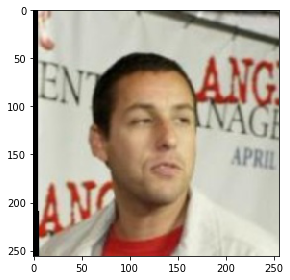

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


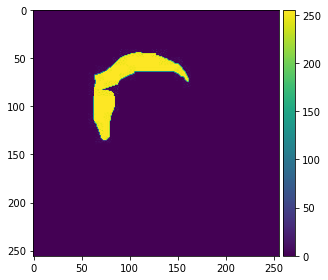

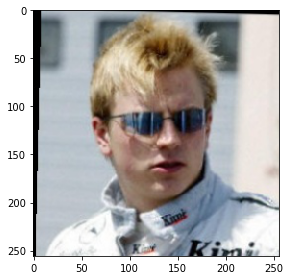

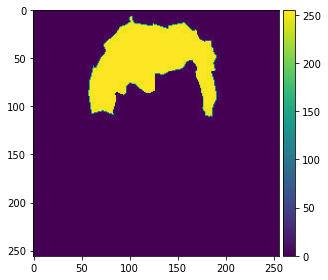

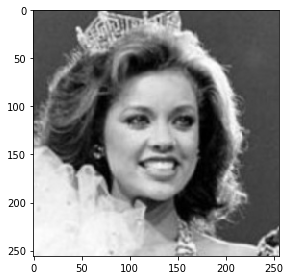

In [0]:
# Check if training images and masks look okay
ix = random.randint(0, numTrain)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Check if validation images and masks look okay
ix = random.randint(0, numVal)
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()

# Check if testing images look okay
ix = random.randint(0, numTest)
imshow(X_test[ix])
plt.show()

#Build model and evaluation metric for image segmentation

In [0]:
# based on metric provided at www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

# Convert data to float point
def castF(x):
    return K.cast(x, K.floatx())

# Convert data to boolean values
def castB(x):
    return K.cast(x, bool)

# Compute intersection over union with smoothing to dampen loss
def iou_loss_core(true,pred):
  
    # Computer intersection of the true mask and the predicted mask
    intersection = true * pred
    
    # Get the background
    notTrue = 1 - true
    
    # Get the union of the true mask and the portion of the predicted mask which is incorrect
    union = true + (notTrue * pred)

    # Return the (intersection + smoothing value)/(union + smoothing value)
    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

# Compute the average IoU for a batch of masks
def mean_iou(true, pred): 

    # Initialize thresholds
    thresholds = [0.5 + (i*.05)  for i in range(10)]

    # Flatten images (batch, pixels) to process batch at once
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    # Convert predicted mask to an array of 0.0 and 1.0 based on the probability
    pred = castF(K.greater(pred, 0.5))

    # Get the total number of mask pixels in the ground truth and the prediciton
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)
    print(trueSum.shape)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    # Get overlap of true mask and predicted mask and convert to boolean array
    truePositiveMask = castB(true1 * pred1)

    # Limiting scope of calculation
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    # Compute iou for true and pred
    iou = iou_loss_core(testTrue,testPred) 
    
    # Get boolean array for ious greater than various thresholds
    truePositives = [castF(K.greater(iou, thresh)) for thresh in thresholds]

    # Get mean of thresholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    # Calculate true negative if target is not present in image
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    # Return average of all of the correctly guess true positives and negatives for the batch
    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [0]:
# Scale features down so that pixel values are between 0 and 1
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0
Y_train = Y_train/255.0
Y_val = Y_val/255.0

In [0]:
# Build autoencoder model based on the model provided at www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855%2Fcode

# create input layer which takes 256X256X3 image data
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Feature compression

# Create convolutional layer with 16 kernels, size 3x3 filter
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
# Create dropout layer for regularization
c1 = Dropout(0.1) (c1)
# Create convolutional layer with 16 kernels, size 3x3 filter
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
# Create maxpooling layer for downsampling
p1 = MaxPooling2D((2, 2)) (c1)

# Create convolutional layer with 32 kernels, size 3x3 filter
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# Create dropout layer for regularization
c2 = Dropout(0.1) (c2)
# Create convolutional layer with 32 kernels, size 3x3 filter
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
# Create maxpooling layer for downsampling
p2 = MaxPooling2D((2, 2)) (c2)

# Create convolutional layer with 64 kernels, size 3x3 filter
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# Create dropout layer for regularization
c3 = Dropout(0.2) (c3)
# Create convolutional layer with 64 kernels, size 3x3 filter
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
# Create maxpooling layer for downsampling
p3 = MaxPooling2D((2, 2)) (c3)

# Create convolutional layer with 128 filters, size 3x3 filter
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# Create dropout layer for regularization
c4 = Dropout(0.2) (c4)
# Create convolutional layer with 128 filters, size 3x3 filter
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# Create maxpooling layer for downsampling
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)



# Bottleneck

# Create convolutional layer with 256 filters, size 3x3 filter
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# Create dropout layer for regularization
c5 = Dropout(0.3) (c5)
# Create convolutional layer with 256 filters, size 3x3 filter
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)


# Create transpose conv layer for upsampling
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
# Link symmetric conv layers to retrieve lost features
u6 = concatenate([u6, c4])
# Create convolutional layer with 128 filters, size 3x3 filter
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# Create dropout layer for regularization
c6 = Dropout(0.2) (c6)
# Create convolutional layer with 128 filters, size 3x3 filter
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# Create transpose conv layer for upsampling
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
# Link symmetric conv layers to retrieve lost features
u7 = concatenate([u7, c3])
# Create convolutional layer with 64 filters, size 3x3 filter
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
# Create dropout layer for regularization
c7 = Dropout(0.2) (c7)
# Create convolutional layer with 64 filters, size 3x3 filter
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

# Create transpose conv layer for upsampling
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
# Link symmetric conv layers to retrieve lost features
u8 = concatenate([u8, c2])
# Create convolutional layer with 32 filters, size 3x3 filter
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
# Create dropout layer for regularization
c8 = Dropout(0.1) (c8)
# Create convolutional layer with 32 filters, size 3x3 filter
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

# Create transpose conv layer for upsampling
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# Link symmetric conv layers to retrieve lost features
u9 = concatenate([u9, c1], axis=3)
# Create convolutional layer with 16 filters, size 3x3 filter
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# Create dropout layer for regularization
c9 = Dropout(0.1) (c9)
# Create convolutional layer with 16 filters, size 3x3 filter
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Output layer for segmentation of 2 classes
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

# Concatenate model
model = Model(inputs=[inputs], outputs=[outputs])

# Build model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])


W0629 01:16:03.572545 139751543875456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 01:16:04.079335 139751543875456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(?,)


In [0]:
# Create early stopping and checkpoint callbacks
earlystop = EarlyStopping(patience=8, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/My Drive/FinalProject/model-best.h5', verbose=1, save_best_only=True)

# Train the model on the training and validation set
results = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    batch_size=16, 
                    epochs=50, 
                    callbacks=[earlystop, checkpoint])

Train on 1500 samples, validate on 500 samples
Epoch 1/50
1488/1500 [============================>.] - ETA: 0s - loss: 0.3484 - mean_iou: 0.0054
Epoch 00001: val_loss improved from inf to 0.30702, saving model to /content/drive/My Drive/FinalProject/model-best.h5
1500/1500 [==============================] - 29s 19ms/sample - loss: 0.3476 - mean_iou: 0.0053 - val_loss: 0.3070 - val_mean_iou: 0.0410
Epoch 2/50
1488/1500 [============================>.] - ETA: 0s - loss: 0.2805 - mean_iou: 0.0093
Epoch 00002: val_loss did not improve from 0.30702
1500/1500 [==============================] - 19s 13ms/sample - loss: 0.2798 - mean_iou: 0.0092 - val_loss: 0.3223 - val_mean_iou: 0.0410
Epoch 3/50
1488/1500 [============================>.] - ETA: 0s - loss: 0.2458 - mean_iou: 0.0233
Epoch 00003: val_loss improved from 0.30702 to 0.22877, saving model to /content/drive/My Drive/FinalProject/model-best.h5
1500/1500 [==============================] - 20s 14ms/sample - loss: 0.2458 - mean_iou: 0.02

#Use model to make predictions and check result

In [0]:
# Predict on testing images from best model
model = load_model('/content/drive/My Drive/FinalProject/model-best.h5', custom_objects={'mean_iou': mean_iou})
predict = model.predict(X_test, verbose=1)

# Threshold predictions to convert array values to binary for black and white
predict = (predict > 0.5).astype(np.uint8)



W0629 01:26:44.370063 139751543875456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 01:26:44.384384 139751543875456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(?,)
927/927 [==============================] - 7s 7ms/sample


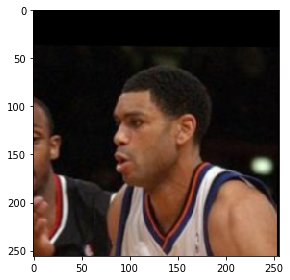

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


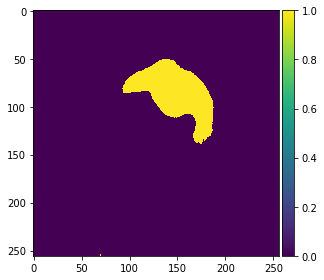

In [0]:
# Check a sample prediction for a test image
ix = random.randint(0, len(predict))
imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(predict[ix]))
plt.show()

#Convert Mask Numpy Arrays to JPG files

In [0]:
from PIL import Image
import numpy

# iterate over all of the test masks
for img_num in tqdm(range(0, numTest)):
  
    # squeeze image back to 2d and scale it back up to black and white
    new_img = Image.fromarray(np.squeeze(predict[img_num])*255)
    
    # save image in test mask folder as a jpg
    new_img.save('/content/drive/My Drive/FinalProject/testing/masks/test_mask_' + str(img_num+1) + '.jpg')

100%|██████████| 927/927 [06:07<00:00,  2.14it/s]


#Encode masks for submission

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
%matplotlib inline  

# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [0]:
# (* update) the input_path using your folder path
input_path = '/content/drive/My Drive/FinalProject/testing/masks'

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    img_size =250
    mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('/content/drive/My Drive/FinalProject/testing/', 'test_seg.csv'), index=False)